<a href="https://colab.research.google.com/github/RajeshworM/Yield_Modelling_Automation/blob/main/Automation_Yield.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Upload Your Excel File**
In a Colab cell:

 **2. Load the excel Data**


 **3. Create Deflated Economic Ratios**

**4. Fit a Quick OLS Model**
Use statsmodels:

**NEW**

In [ ]:
from google.colab import files
uploaded = files.upload()

import pandas as pd

# Replace with the actual filename you upload
df = pd.read_csv("ap_auto.csv")

# Optional: check the first few rows
df.head()




Saving ap_auto.csv to ap_auto.csv


,year,yield,fert,urea,sulf,dap,ptd,exp_price,msp,canal,...,aug1_min_30,aug2_min_30,sep1_min_30,sep2_min_30,oct1_min_30,oct2_min_30,nov1_min_30,nov2_min_30,dec1_min_30,dec2_min_30
0,2000,2741.0,69.80,77.0,52.0,67.0,80.0,1122.10,510,0.55,...,24.87,24.06,24.13,24.00,24.00,23.25,22.93,22.07,21.07,20.29
1,2001,2679.0,71.24,77.0,55.0,67.0,85.7,1044.43,530,0.64,...,25.00,25.44,24.93,25.00,24.53,24.13,23.93,22.40,21.33,21.73
2,2002,2396.0,74.32,81.0,59.0,65.0,86.3,1140.43,550,0.57,...,25.00,25.38,25.07,25.00,25.00,24.00,23.13,22.47,20.53,20.87
3,2003,2770.0,74.76,81.0,61.0,65.0,85.3,1008.33,550,0.54,...,25.00,25.44,25.00,25.00,24.53,24.00,23.33,22.73,20.73,21.36
4,2004,2886.0,75.44,81.0,64.0,65.0,86.7,1033.33,560,0.61,...,25.00,25.63,25.27,24.47,24.00,23.31,23.00,22.13,22.00,20.00


<font color='Blue'> <font size='4'> **Selection for Economic Incentive Part**

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Load your dataset
df = pd.read_csv("ap_auto.csv")

# Create MSP/input ratios
df["msp_fert"] = df["msp"] / df["fert"]
df["msp_urea"] = df["msp"] / df["urea"]
df["msp_sulf"] = df["msp"] / df["sulf"]
df["msp_dap"] = df["msp"] / df["dap"]
df["msp_ptd"] = df["msp"] / df["ptd"]

# Create EXP/input ratios
df["exp_fert"] = df["exp_price"] / df["fert"]
df["exp_urea"] = df["exp_price"] / df["urea"]
df["exp_sulf"] = df["exp_price"] / df["sulf"]
df["exp_dap"] = df["exp_price"] / df["dap"]
df["exp_ptd"] = df["exp_price"] / df["ptd"]

# Filter to modeling period
df_model = df[df["year"].between(2000, 2023)].copy()

# Function to compute t-statistic
def get_tstat(df, varname):
    X = sm.add_constant(df[[varname]])
    y = df["yield"]
    model = sm.OLS(y, X).fit()
    return model.tvalues[varname], model

# All economic variables (MSP + EXP)
all_vars = [
    "msp_urea", "msp_dap", "msp_sulf", "msp_fert", "msp_ptd",
    "exp_urea", "exp_dap", "exp_sulf", "exp_fert", "exp_ptd"
]

selected = []
best_tstat = -1

print("=== Economic Incentive Variable Selection ===")
for var in all_vars:
    if not selected:
        tstat, model = get_tstat(df_model, var)
        best_tstat = tstat
        selected.append(var)
        print(f"Selected first: {var} with t-stat = {tstat:.2f}")
    else:
        df_model["temp_avg"] = df_model[selected + [var]].mean(axis=1)
        tstat_new, _ = get_tstat(df_model, "temp_avg")
        print(f"Trying {var}: avg t-stat = {tstat_new:.2f} vs old {best_tstat:.2f}")
        if tstat_new > best_tstat:
            selected.append(var)
            best_tstat = tstat_new
            print(f"✅ Added: {var}, new t-stat = {tstat_new:.2f}")
        else:
            print(f"❌ Rejected: {var}")

print("\n✅ Final selected economic incentive variables:", selected)

# Create final combined variable
df["econ_incentive"] = df[selected].mean(axis=1)
df_model["econ_incentive"] = df_model[selected].mean(axis=1)

# Final model
X = sm.add_constant(df_model[["econ_incentive"]])
y = df_model["yield"]
final_model = sm.OLS(y, X).fit()

# 📅 Show sample period before printing summary
print(f"\n📅 Sample period used: {df_model['year'].min()} to {df_model['year'].max()}")

print("\n=== FINAL ECONOMIC MODEL SUMMARY ===")
print(final_model.summary())



=== Economic Incentive Variable Selection ===
Selected first: msp_urea with t-stat = 5.15
Trying msp_dap: avg t-stat = 4.98 vs old 5.15
❌ Rejected: msp_dap
Trying msp_sulf: avg t-stat = 5.36 vs old 5.15
✅ Added: msp_sulf, new t-stat = 5.36
Trying msp_fert: avg t-stat = 5.34 vs old 5.36
❌ Rejected: msp_fert
Trying msp_ptd: avg t-stat = 5.27 vs old 5.36
❌ Rejected: msp_ptd
Trying exp_urea: avg t-stat = 4.79 vs old 5.36
❌ Rejected: exp_urea
Trying exp_dap: avg t-stat = 4.71 vs old 5.36
❌ Rejected: exp_dap
Trying exp_sulf: avg t-stat = 4.46 vs old 5.36
❌ Rejected: exp_sulf
Trying exp_fert: avg t-stat = 4.72 vs old 5.36
❌ Rejected: exp_fert
Trying exp_ptd: avg t-stat = 4.71 vs old 5.36
❌ Rejected: exp_ptd

✅ Final selected economic incentive variables: ['msp_urea', 'msp_sulf']

📅 Sample period used: 2000 to 2023

=== FINAL ECONOMIC MODEL SUMMARY ===
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:              

In [ ]:
# === TESTING GROUNDWATER VARIABLES (POSITIVE SIGN ONLY, MAX 2 INDEX GROUPS) ===

groundwater_ids = [28, 29, 30]  # Can be any number serial or not serial etc.
groundwater_vars = [f"groundwater_{i}" for i in groundwater_ids]

gw_index_1 = []
gw_index_2 = []
tstat_1 = -1
tstat_2 = -1

print("\n=== Testing Groundwater Variables (Positive Significance Only, t > 1.65) ===")

for gw_var in groundwater_vars:
    if gw_var not in df_model.columns:
        print(f"⚠️ Skipping {gw_var} (not in dataset)")
        continue

    # Check t-stat and sign with econ_incentive
    X = sm.add_constant(df_model[["econ_incentive", gw_var]])
    y = df_model["yield"]
    model = sm.OLS(y, X).fit()
    coef = model.params.get(gw_var, 0)
    tstat = model.tvalues.get(gw_var, 0)

    print(f"{gw_var}: coef = {coef:.2f}, t-stat = {tstat:.2f}")

    if coef > 0 and tstat > 1.65:
        if not gw_index_1:
            gw_index_1.append(gw_var)
            df_model["gw_index_1"] = df_model[gw_index_1].mean(axis=1)
            tstat_1, _ = get_tstat(df_model, "gw_index_1")
            print(f"✅ Starting gw_index_1 with: {gw_var}")
        else:
            # Try adding to index 1
            temp_1 = gw_index_1 + [gw_var]
            df_model["temp_index_1"] = df_model[temp_1].mean(axis=1)
            new_tstat_1, _ = get_tstat(df_model, "temp_index_1")

            if new_tstat_1 > tstat_1:
                gw_index_1.append(gw_var)
                df_model["gw_index_1"] = df_model[gw_index_1].mean(axis=1)
                tstat_1 = new_tstat_1
                print(f"✅ Added to gw_index_1: {gw_var}")
            elif not gw_index_2:
                gw_index_2.append(gw_var)
                df_model["gw_index_2"] = df_model[gw_index_2].mean(axis=1)
                tstat_2, _ = get_tstat(df_model, "gw_index_2")
                print(f"📌 Started gw_index_2 with: {gw_var}")
            else:
                # Try adding to index 2
                temp_2 = gw_index_2 + [gw_var]
                df_model["temp_index_2"] = df_model[temp_2].mean(axis=1)
                new_tstat_2, _ = get_tstat(df_model, "temp_index_2")

                if new_tstat_2 > tstat_2:
                    gw_index_2.append(gw_var)
                    df_model["gw_index_2"] = df_model[gw_index_2].mean(axis=1)
                    tstat_2 = new_tstat_2
                    print(f"✅ Added to gw_index_2: {gw_var}")
                else:
                    print(f"❌ Skipped: {gw_var} — no t-stat improvement in either index")
    elif coef < 0 and abs(tstat) > 1.65:
        print(f"⚠️ Negative significant — excluded: {gw_var}")
    else:
        print(f"❌ Not significant: {gw_var}")

# Final modeling with up to two indices
model_vars = ["econ_incentive"]
if gw_index_1:
    df_model["gw_index_1"] = df_model[gw_index_1].mean(axis=1)
    model_vars.append("gw_index_1")
if gw_index_2:
    df_model["gw_index_2"] = df_model[gw_index_2].mean(axis=1)
    model_vars.append("gw_index_2")

X = sm.add_constant(df_model[model_vars])
y = df_model["yield"]
final_model = sm.OLS(y, X).fit()

print(f"\n📅 Sample period: {df_model['year'].min()} to {df_model['year'].max()}")
print("\n=== FINAL MODEL: Economic Incentive + Groundwater Index 1/2 ===")
print(final_model.summary())



=== Testing Groundwater Variables (Positive Significance Only, t > 1.65) ===
groundwater_28: coef = -2874.10, t-stat = -1.55
❌ Not significant: groundwater_28
groundwater_29: coef = -1482.33, t-stat = -1.17
❌ Not significant: groundwater_29
groundwater_30: coef = -1197.22, t-stat = -0.67
❌ Not significant: groundwater_30

📅 Sample period: 2000 to 2023

=== FINAL MODEL: Economic Incentive + Groundwater Index 1/2 ===
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     28.70
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           2.23e-05
Time:                        10:45:18   Log-Likelihood:                -162.43
No. Observations:                  24   AIC:                             328.9
Df Residuals:              

In [ ]:
# === RESERVOIR VARIABLE SELECTION (with group-wise t-stat improvement check) ===

#Loops for reservoirs volume (Intensity)

reservoir_ids = [1, 2, 3, 4, 5, 6, 7, 8]  # Can be [1, 2, 4, 6, 7] etc.
reservoir_vars = [f"reservoir_{i}" for i in reservoir_ids]

# Base predictors already selected
base_predictors = ["econ_incentive"]
if "gw_index_1" in df_model.columns:
    base_predictors.append("gw_index_1")
if "gw_index_2" in df_model.columns:
    base_predictors.append("gw_index_2")

# Helper to test t-stat of last predictor
def test_tstat(df_model, predictors, target="yield"):
    X = sm.add_constant(df_model[predictors])
    y = df_model[target]
    model = sm.OLS(y, X).fit()
    return model.tvalues[predictors[-1]], model

reservoir_pos = []
reservoir_pos_sep = []
reservoir_neg = []
reservoir_neg_sep = []

best_tstat_pos = -1e9
best_tstat_neg = -1e9

print("\n=== Testing Reservoir Variables (with econ_incentive + groundwater indices) ===")

for res_var in reservoir_vars:
    if res_var not in df_model.columns:
        print(f"⚠️ Skipping {res_var} (not in dataset)")
        continue

    X = sm.add_constant(df_model[base_predictors + [res_var]])
    y = df_model["yield"]
    model = sm.OLS(y, X).fit()
    coef = model.params.get(res_var, 0)
    tstat = model.tvalues.get(res_var, 0)

    print(f"{res_var}: coef = {coef:.2f}, t-stat = {tstat:.2f}")

    if abs(tstat) >= 1.65:
        sign = "pos" if coef > 0 else "neg"

        if sign == "pos":
            if not reservoir_pos:
                reservoir_pos.append(res_var)
                best_tstat_pos = tstat
                print(f"✅ First positive significant: {res_var}")
            else:
                temp_vars = reservoir_pos + [res_var]
                df_model["temp_avg_pos"] = df_model[temp_vars].mean(axis=1)
                tstat_new, _ = test_tstat(df_model, base_predictors + ["temp_avg_pos"])

                print(f"→ Testing avg of {temp_vars}: t-stat = {tstat_new:.2f} (prev best = {best_tstat_pos:.2f})")
                if tstat_new > best_tstat_pos:
                    reservoir_pos.append(res_var)
                    best_tstat_pos = tstat_new
                    print(f"✅ Added to positive group: {res_var}")
                else:
                    reservoir_pos_sep.append(res_var)
                    print(f"❌ Kept separate (positive): {res_var}")
        else:
            if not reservoir_neg:
                reservoir_neg.append(res_var)
                best_tstat_neg = tstat
                print(f"✅ First negative significant: {res_var}")
            else:
                temp_vars = reservoir_neg + [res_var]
                df_model["temp_avg_neg"] = df_model[temp_vars].mean(axis=1)
                tstat_new, _ = test_tstat(df_model, base_predictors + ["temp_avg_neg"])

                print(f"→ Testing avg of {temp_vars}: t-stat = {tstat_new:.2f} (prev best = {best_tstat_neg:.2f})")
                if tstat_new > best_tstat_neg:
                    reservoir_neg.append(res_var)
                    best_tstat_neg = tstat_new
                    print(f"✅ Added to negative group: {res_var}")
                else:
                    reservoir_neg_sep.append(res_var)
                    print(f"❌ Kept separate (negative): {res_var}")
    else:
        print(f"❌ Not significant: {res_var}")

# === BUILD RESERVOIR VARIABLES ===
final_model_vars = base_predictors.copy()

if reservoir_pos:
    df_model["reservoir_pos_index"] = df_model[reservoir_pos].mean(axis=1)
    final_model_vars.append("reservoir_pos_index")
for var in reservoir_pos_sep:
    final_model_vars.append(var)

if reservoir_neg:
    df_model["reservoir_neg_index"] = df_model[reservoir_neg].mean(axis=1)
    final_model_vars.append("reservoir_neg_index")
for var in reservoir_neg_sep:
    final_model_vars.append(var)

# === FINAL MODEL ===
X = sm.add_constant(df_model[final_model_vars])
y = df_model["yield"]
final_model = sm.OLS(y, X).fit()

print(f"\n📅 Sample period: {df_model['year'].min()} to {df_model['year'].max()}")
print("\n=== FINAL MODEL: Economic Incentive + Groundwater + Reservoirs ===")
print(final_model.summary())



=== Testing Reservoir Variables (with econ_incentive + groundwater indices) ===
reservoir_1: coef = 0.16, t-stat = 1.26
❌ Not significant: reservoir_1
reservoir_2: coef = 0.20, t-stat = 1.67
✅ First positive significant: reservoir_2
reservoir_3: coef = -0.10, t-stat = -0.31
❌ Not significant: reservoir_3
reservoir_4: coef = -2.87, t-stat = -1.73
✅ First negative significant: reservoir_4
reservoir_5: coef = -0.02, t-stat = -0.01
❌ Not significant: reservoir_5
reservoir_6: coef = 1.64, t-stat = 0.60
❌ Not significant: reservoir_6
reservoir_7: coef = 1.03, t-stat = 0.93
❌ Not significant: reservoir_7
reservoir_8: coef = -0.16, t-stat = -0.45
❌ Not significant: reservoir_8

📅 Sample period: 2000 to 2023

=== FINAL MODEL: Economic Incentive + Groundwater + Reservoirs ===
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:         

In [ ]:
# === TESTING IRRIGATION VARIABLES (T > 1.65, POS & NEG, COMPARE T-STAT ON AVERAGING) ===
irrigation_vars = ["canal", "well", "tank", "oth", "nia"]
irrigation_pos = []
irrigation_neg = []
irrigation_pos_groups = []
irrigation_neg_groups = []

print("\n=== Testing Irrigation Variables (with econ_incentive + groundwater + reservoir indices) ===")

# Base model variables
model_vars_base = ["econ_incentive"]
for col in ["gw_index_1", "gw_index_2", "reservoir_pos_index", "reservoir_neg_index"]:
    if col in df_model.columns:
        model_vars_base.append(col)

for irr_var in irrigation_vars:
    if irr_var not in df_model.columns:
        print(f"⚠️ Skipping {irr_var} (not in dataset)")
        continue

    # Try model: yield ~ econ_incentive + groundwater + reservoir + irr_var
    X = sm.add_constant(df_model[model_vars_base + [irr_var]])
    y = df_model["yield"]
    model = sm.OLS(y, X).fit()
    coef = model.params.get(irr_var, 0)
    tstat = model.tvalues.get(irr_var, 0)

    print(f"{irr_var}: coef = {coef:.2f}, t-stat = {tstat:.2f}")

    if abs(tstat) > 1.65:
        sign = "pos" if coef > 0 else "neg"
        group_list = irrigation_pos if sign == "pos" else irrigation_neg
        group_sets = irrigation_pos_groups if sign == "pos" else irrigation_neg_groups

        if not group_list:
            group_list.append(irr_var)
            group_sets.append([irr_var])
            print(f"✅ {sign.capitalize()} & significant (starting new group): {irr_var}")
        else:
            test_group = group_list + [irr_var]
            X_test = sm.add_constant(df_model[model_vars_base + [df_model[test_group].mean(axis=1).rename("test_avg")]])
            model_test = sm.OLS(y, X_test).fit()
            tstat_new = model_test.tvalues.get("test_avg", 0)
            print(f"    ➕ Avg t-stat with {irr_var}: {tstat_new:.2f} (prev best: {tstat:.2f})")

            if abs(tstat_new) > abs(tstat):
                group_list.append(irr_var)
                group_sets[-1] = test_group
                print(f"    ✅ Added to group (improved t-stat): {irr_var}")
            else:
                group_list = [irr_var]
                group_sets.append([irr_var])
                print(f"    ⛔ Kept separate (t-stat dropped): {irr_var}")
    else:
        print(f"❌ Not significant: {irr_var}")

# === BUILD IRRIGATION INDEX VARIABLES ===
for i, group in enumerate(irrigation_pos_groups):
    colname = f"irrigation_pos_{i+1}"
    df_model[colname] = df_model[group].mean(axis=1)

for i, group in enumerate(irrigation_neg_groups):
    colname = f"irrigation_neg_{i+1}"
    df_model[colname] = df_model[group].mean(axis=1)

# === FINAL MODEL: ECON + GW + RESERVOIR + IRRIGATION ===
final_model_vars = model_vars_base.copy()

# Add irrigation indices
for col in df_model.columns:
    if col.startswith("irrigation_pos_") or col.startswith("irrigation_neg_"):
        final_model_vars.append(col)

X = sm.add_constant(df_model[final_model_vars])
y = df_model["yield"]
final_model_irrigation = sm.OLS(y, X).fit()

print(f"\n📅 Sample period: {df_model['year'].min()} to {df_model['year'].max()}")
print("\n=== FINAL MODEL: Economic + Groundwater + Reservoir + Irrigation ===")
print(final_model_irrigation.summary())



=== Testing Irrigation Variables (with econ_incentive + groundwater + reservoir indices) ===
canal: coef = -119.42, t-stat = -0.33
❌ Not significant: canal
well: coef = -269.85, t-stat = -0.88
❌ Not significant: well
tank: coef = -100.09, t-stat = -0.05
❌ Not significant: tank
oth: coef = -5888.81, t-stat = -0.95
❌ Not significant: oth
nia: coef = -263.26, t-stat = -0.91
❌ Not significant: nia

📅 Sample period: 2000 to 2023

=== FINAL MODEL: Economic + Groundwater + Reservoir + Irrigation ===
                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.668
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     13.44
Date:                Wed, 06 Aug 2025   Prob (F-statistic):           4.96e-05
Time:                        10:45:18   Log-Likelihood:                -159.20
No. Observations:          

In [ ]:
# === RAINFALL VARIABLE SELECTION (T > 1.65) ===


#Rainfall monthly - Loop

regions = [28, 29, 30]
months = range(5, 13)  # Months 5 to 12
rainfall_vars = [f"m{region}_rf{month}" for region in regions for month in months]


rainfall_vars = list(dict.fromkeys(rainfall_vars))  # Remove duplicates if any

# === Define base model (econ + significant reservoir only) ===
model_vars_base = ["econ_incentive"]
if "reservoir_pos_index" in df_model.columns:
    model_vars_base.append("reservoir_pos_index")
if "reservoir_neg_index" in df_model.columns:
    model_vars_base.append("reservoir_neg_index")

rain_pos_groups = []
rain_neg_groups = []

print("\n=== Testing Rainfall Variables (with base model) ===")
for rf_var in rainfall_vars:
    if rf_var not in df_model.columns:
        print(f"⚠️ Skipping {rf_var} (not found)")
        continue

    X = sm.add_constant(df_model[model_vars_base + [rf_var]])
    y = df_model["yield"]
    model = sm.OLS(y, X).fit()
    tstat = model.tvalues.get(rf_var, 0)
    coef = model.params.get(rf_var, 0)

    print(f"{rf_var}: coef = {coef:.2f}, t-stat = {tstat:.2f}")

    if abs(tstat) > 1.65:
        group_list = None
        if coef > 0 and rain_pos_groups:
            group_list = rain_pos_groups[-1]
        elif coef < 0 and rain_neg_groups:
            group_list = rain_neg_groups[-1]

        if group_list:
            test_group = group_list + [rf_var]
            df_model["test_avg"] = df_model[test_group].mean(axis=1)
            X_test = sm.add_constant(df_model[model_vars_base + ["test_avg"]])
            model_test = sm.OLS(y, X_test).fit()
            tstat_new = model_test.tvalues.get("test_avg", 0)

            if abs(tstat_new) > abs(model.tvalues.get(group_list[-1], 0)):
                group_list.append(rf_var)
                print(f"🔁 Added to group (t-stat ↑ to {tstat_new:.2f})")
            else:
                if coef > 0:
                    rain_pos_groups.append([rf_var])
                else:
                    rain_neg_groups.append([rf_var])
                print("➕ New group started (t-stat not improved)")
            del df_model["test_avg"]
        else:
            if coef > 0:
                rain_pos_groups.append([rf_var])
            else:
                rain_neg_groups.append([rf_var])
            print("🆕 First group started")
    else:
        print("❌ Not significant")

# === BUILD RAINFALL INDEX VARIABLES ===
for i, group in enumerate(rain_pos_groups):
    df_model[f"rain_index_pos_{i+1}"] = df_model[group].mean(axis=1)
for i, group in enumerate(rain_neg_groups):
    df_model[f"rain_index_neg_{i+1}"] = df_model[group].mean(axis=1)

# === FINAL MODEL: BASE + RAIN INDICES ===
final_model_vars = model_vars_base.copy()
for col in df_model.columns:
    if col.startswith("rain_index_pos_") or col.startswith("rain_index_neg_"):
        final_model_vars.append(col)

X = sm.add_constant(df_model[final_model_vars])
y = df_model["yield"]
final_model_rainfall = sm.OLS(y, X).fit()

print(f"\n📅 Sample period: {df_model['year'].min()} to {df_model['year'].max()}")
print("\n=== FINAL MODEL: Economic + Selected GW/Res/Irr + Rainfall ===")
print(final_model_rainfall.summary())



=== Testing Rainfall Variables (with base model) ===
m28_rf5: coef = -0.04, t-stat = -0.04
❌ Not significant
m28_rf6: coef = -0.21, t-stat = -0.20
❌ Not significant
m28_rf7: coef = 0.44, t-stat = 0.45
❌ Not significant
m28_rf8: coef = -0.13, t-stat = -0.16
❌ Not significant
⚠️ Skipping m28_rf9 (not found)
m28_rf10: coef = -0.69, t-stat = -1.54
❌ Not significant
m28_rf11: coef = -1.15, t-stat = -2.29
🆕 First group started
m28_rf12: coef = 0.68, t-stat = 0.63
❌ Not significant
m29_rf5: coef = -0.24, t-stat = -0.10
❌ Not significant
m29_rf6: coef = -0.83, t-stat = -1.00
❌ Not significant
m29_rf7: coef = 0.29, t-stat = 0.73
❌ Not significant
m29_rf8: coef = -0.36, t-stat = -0.66
❌ Not significant
⚠️ Skipping m29_rf9 (not found)
m29_rf10: coef = -1.38, t-stat = -2.04
🔁 Added to group (t-stat ↑ to -3.60)
m29_rf11: coef = -4.59, t-stat = -1.77
🔁 Added to group (t-stat ↑ to -3.55)
m29_rf12: coef = 3.67, t-stat = 0.70
❌ Not significant
m30_rf5: coef = 1.15, t-stat = 0.88
❌ Not significant
m30_

In [ ]:
import statsmodels.api as sm

# === 1. Prepare Temperature Variable Lists (Max and Min, Regions 28–30, July–Dec) ===
temp_max_vars = [
    f"{m}_max_{r}" for m in [
        "jul1", "jul2", "aug1", "aug2", "sep1", "sep2",
        "oct1", "oct2", "nov1", "nov2", "dec1", "dec2"
    ] for r in [28, 29, 30]
]

temp_min_vars = [
    f"{m}_min_{r}" for m in [
        "jul1", "jul2", "aug1", "aug2", "sep1", "sep2",
        "oct1", "oct2", "nov1", "nov2", "dec1", "dec2"
    ] for r in [28, 29, 30]
]

# === 2. Define Base Model (econ + significant reservoir + rainfall indices) ===
base_vars = ["econ_incentive"]
y_base = df_model["yield"]

# Check reservoir_pos_index
if "reservoir_pos_index" in df_model.columns:
    X_test = sm.add_constant(df_model[base_vars + ["reservoir_pos_index"]])
    model = sm.OLS(y_base, X_test).fit()
    t_stat = model.tvalues.get("reservoir_pos_index", 0)
    if abs(t_stat) >= 1.65:
        base_vars.append("reservoir_pos_index")

# Check reservoir_neg_index
if "reservoir_neg_index" in df_model.columns:
    X_test = sm.add_constant(df_model[base_vars + ["reservoir_neg_index"]])
    model = sm.OLS(y_base, X_test).fit()
    t_stat = model.tvalues.get("reservoir_neg_index", 0)
    if abs(t_stat) >= 1.65:
        base_vars.append("reservoir_neg_index")

# Check rainfall index variables
for col in df_model.columns:
    if col.startswith("rain_index_pos_") or col.startswith("rain_index_neg_"):
        X_test = sm.add_constant(df_model[base_vars + [col]])
        model = sm.OLS(y_base, X_test).fit()
        t_stat = model.tvalues.get(col, 0)
        if abs(t_stat) >= 1.65:
            base_vars.append(col)

print(f"✅ Final base variables for temperature model: {base_vars}")

# === 3. Cumulative Temperature Selection Function ===
def select_temp_vars(temp_vars, label):
    selected_vars = []
    pos_vars = []
    neg_vars = []
    current_vars = base_vars.copy()

    print(f"\n=== Cumulative Testing: {label} Variables ===")
    for var in temp_vars:
        if var not in df_model.columns:
            print(f"⚠️ Skipping {var} (not found)")
            continue

        test_vars = current_vars + [var]
        X = sm.add_constant(df_model[test_vars])
        y = df_model["yield"]
        model = sm.OLS(y, X).fit()

        temp_t = model.tvalues.get(var, 0)
        prior_tstats = {v: model.tvalues.get(v, 0) for v in current_vars}
        prior_ok = all(abs(t) >= 1.65 for t in prior_tstats.values())

        print(f"\n▶️ Testing {var}: t = {temp_t:.2f}")
        for v, t in prior_tstats.items():
            print(f"   - {v}: t = {t:.2f} {'✅' if abs(t) >= 1.65 else '❌'}")

        if abs(temp_t) >= 1.65 and prior_ok:
            selected_vars.append(var)
            current_vars.append(var)
            if temp_t > 0:
                pos_vars.append(var)
                print(f"✅ Accepted (positive)")
            else:
                neg_vars.append(var)
                print(f"✅ Accepted (negative)")
        elif abs(temp_t) >= 1.65:
            print("⚠️ Temp var is significant but weakens prior variables — rejected")
        else:
            print("❌ Not significant — rejected")

    return pos_vars, neg_vars

# === 4. Apply to Max and Min Temperature Sets ===
max_pos_vars, max_neg_vars = select_temp_vars(temp_max_vars, "Max")
min_pos_vars, min_neg_vars = select_temp_vars(temp_min_vars, "Min")

# === 5. Build Temperature Indexes ===
if max_pos_vars:
    df_model["temp_max_pos_index"] = df_model[max_pos_vars].mean(axis=1)
if max_neg_vars:
    df_model["temp_max_neg_index"] = df_model[max_neg_vars].mean(axis=1)
if min_pos_vars:
    df_model["temp_min_pos_index"] = df_model[min_pos_vars].mean(axis=1)
if min_neg_vars:
    df_model["temp_min_neg_index"] = df_model[min_neg_vars].mean(axis=1)

# === 6. Final Model: Base + Selected Temperature Indexes ===
final_model_vars = base_vars.copy()
for index_var in [
    "temp_max_pos_index", "temp_max_neg_index",
    "temp_min_pos_index", "temp_min_neg_index"
]:
    if index_var in df_model.columns:
        final_model_vars.append(index_var)

X_final = sm.add_constant(df_model[final_model_vars])
y_final = df_model["yield"]
final_model = sm.OLS(y_final, X_final).fit()

# === 7. Final Output ===
print(f"\n📅 Sample Period: {df_model['year'].min()} to {df_model['year'].max()}")
print("=== FINAL MODEL: Econ + Reservoir + Rain + Selected Temp Indexes ===")
print(final_model.summary())


✅ Final base variables for temperature model: ['econ_incentive', 'reservoir_pos_index', 'reservoir_neg_index', 'rain_index_neg_1']

=== Cumulative Testing: Max Variables ===

▶️ Testing jul1_max_28: t = -0.52
   - econ_incentive: t = 7.83 ✅
   - reservoir_pos_index: t = 2.00 ✅
   - reservoir_neg_index: t = -1.86 ✅
   - rain_index_neg_1: t = -3.52 ✅
❌ Not significant — rejected

▶️ Testing jul1_max_29: t = -0.74
   - econ_incentive: t = 7.44 ✅
   - reservoir_pos_index: t = 1.90 ✅
   - reservoir_neg_index: t = -1.93 ✅
   - rain_index_neg_1: t = -3.52 ✅
❌ Not significant — rejected

▶️ Testing jul1_max_30: t = -1.04
   - econ_incentive: t = 7.38 ✅
   - reservoir_pos_index: t = 1.88 ✅
   - reservoir_neg_index: t = -2.06 ✅
   - rain_index_neg_1: t = -3.52 ✅
❌ Not significant — rejected

▶️ Testing jul2_max_28: t = 0.05
   - econ_incentive: t = 7.31 ✅
   - reservoir_pos_index: t = 1.81 ✅
   - reservoir_neg_index: t = -2.08 ✅
   - rain_index_neg_1: t = -3.44 ✅
❌ Not significant — rejected

▶️

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === 7. VIF Calculation ===
print("\n=== VIF (Variance Inflation Factor) for Final Model Variables ===")
vif_data = df_model[final_model_vars].copy()
vif_data = sm.add_constant(vif_data)

vif_df = pd.DataFrame()
vif_df["Variable"] = vif_data.columns
vif_df["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]

print(vif_df)



=== VIF (Variance Inflation Factor) for Final Model Variables ===
              Variable          VIF
0                const  3794.476726
1       econ_incentive     1.239527
2  reservoir_pos_index     1.161693
3  reservoir_neg_index     1.042890
4     rain_index_neg_1     1.043366
5   temp_max_pos_index     1.131754
6   temp_max_neg_index     1.058846


In [ ]:
print(df[df["year"].isin([2024, 2025])][["year", "msp_urea", "msp_sulf", "reservoir_2", "reservoir_4", "m28_rf11", "m29_rf10", "m29_rf11", "dec2_max_29", "nov2_max_29"]])


    year   msp_urea   msp_sulf  reservoir_2  reservoir_4  m28_rf11  m29_rf10  \
24  2024  19.827586  18.744906          223            0      37.6      60.5   
25  2025  20.436508  18.397142          311           27     113.1      95.8   

    m29_rf11  dec2_max_29  nov2_max_29  
24       5.9        30.25        30.26  
25      23.0        30.15        31.14  


In [ ]:
# ✅ Recreate variables for all years (including 2024 and 2025)
df["econ_incentive"] = df[["msp_urea", "msp_sulf"]].mean(axis=1)
df["reservoir_pos_index"] = df["reservoir_2"]
df["reservoir_neg_index"] = df["reservoir_4"]
df["rain_index_neg_1"] = df[["m28_rf11", "m29_rf10", "m29_rf11"]].mean(axis=1)
df["temp_max_pos_index"] = df["dec2_max_29"]
df["temp_max_neg_index"] = df["nov2_max_29"]

# 📦 Extract 2024–2025 data for validation/forecast
df_forecast = df[df["year"].isin([2024, 2025])].copy()

# Show the variables used in the model
print(df_forecast[["year", "econ_incentive", "reservoir_pos_index", "reservoir_neg_index","rain_index_neg_1", "temp_max_pos_index","temp_max_neg_index"]])


    year  econ_incentive  reservoir_pos_index  reservoir_neg_index  \
24  2024       19.286246                  223                    0   
25  2025       19.416825                  311                   27   

    rain_index_neg_1  temp_max_pos_index  temp_max_neg_index  
24         34.666667               30.25               30.26  
25         77.300000               30.15               31.14  


In [ ]:
X_forecast = sm.add_constant(df_forecast[[
    "econ_incentive",
    "reservoir_pos_index",
    "reservoir_neg_index",
    "rain_index_neg_1",
    "temp_max_pos_index",
    "temp_max_neg_index"
]])


In [ ]:
df_forecast["yield_predicted"] = final_model.predict(X_forecast)
print(df_forecast[["year", "yield",  "yield_predicted"]])


    year   yield  yield_predicted
24  2024  3619.0      3831.011422
25  2025     NaN      3553.966052


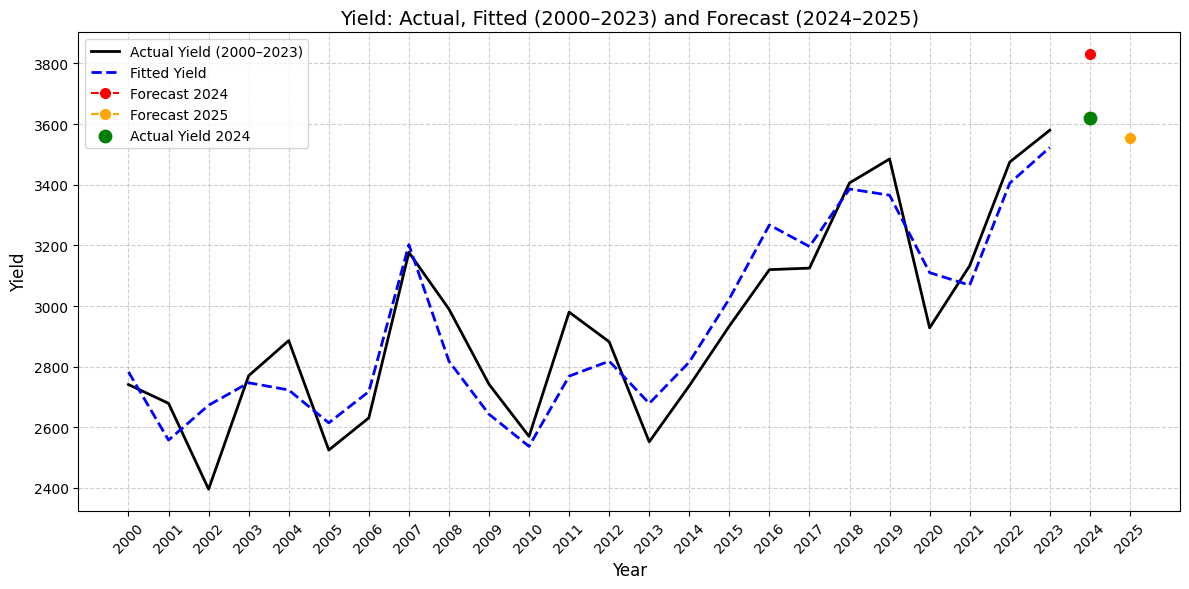

In [ ]:
import matplotlib.pyplot as plt

# Sample data (2000–2023)
sample_years = df_model["year"]
actual_yield = df_model["yield"]
fitted_yield = final_model.fittedvalues

# Forecast data
forecast_2024 = df_forecast[df_forecast["year"] == 2024]
forecast_2025 = df_forecast[df_forecast["year"] == 2025]

# Check if actual 2024 yield is available
has_actual_2024 = "yield" in forecast_2024.columns and not pd.isna(forecast_2024["yield"].values[0])

# Plotting
plt.figure(figsize=(12, 6))

# Actual yield (2000–2023)
plt.plot(sample_years, actual_yield, label="Actual Yield (2000–2023)", color="black", linewidth=2)

# Fitted yield
plt.plot(sample_years, fitted_yield, label="Fitted Yield", color="blue", linestyle="--", linewidth=2)

# Forecast 2024 (line)
plt.plot(forecast_2024["year"], forecast_2024["yield_predicted"], label="Forecast 2024", color="red", linestyle="--", marker="o", markersize=7)

# Forecast 2025 (line)
plt.plot(forecast_2025["year"], forecast_2025["yield_predicted"], label="Forecast 2025", color="orange", linestyle="--", marker="o", markersize=7)

# Actual 2024 yield (dot)
if has_actual_2024:
    plt.scatter(forecast_2024["year"], forecast_2024["yield"], color="green", label="Actual Yield 2024", zorder=5, s=80)

# Labels
plt.title("Yield: Actual, Fitted (2000–2023) and Forecast (2024–2025)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Yield", fontsize=12)
plt.xticks(range(2000, 2026), rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


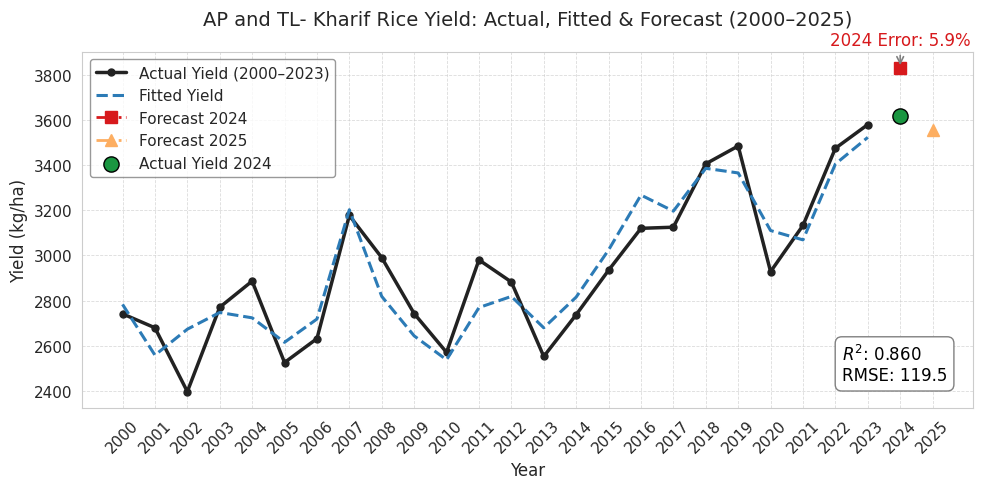

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# -- Compute model performance for training period --
y_true = df_model["yield"]
y_pred = final_model.fittedvalues

# ✅ Compatible RMSE calculation
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Forecast data
forecast_2024 = df_forecast[df_forecast["year"] == 2024]
forecast_2025 = df_forecast[df_forecast["year"] == 2025]

# Check if actual 2024 yield is available
has_actual_2024 = "yield" in forecast_2024.columns and not pd.isna(forecast_2024["yield"].values[0])

# -- Style setup --
sns.set_style("whitegrid")
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "font.size": 10,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# Plot
plt.figure(figsize=(10, 5))

# Actual yield (2000–2023)
plt.plot(df_model["year"], df_model["yield"], label="Actual Yield (2000–2023)",
         color="#222222", linewidth=2.5, marker='o', markersize=5)

# Fitted yield (2000–2023)
plt.plot(df_model["year"], final_model.fittedvalues, label="Fitted Yield",
         color="#2C7BB6", linestyle="--", linewidth=2.2)

# Forecasts
plt.plot(forecast_2024["year"], forecast_2024["yield_predicted"],
         label="Forecast 2024", color="#D7191C", linestyle="-.", marker="s", markersize=8, linewidth=2)
plt.plot(forecast_2025["year"], forecast_2025["yield_predicted"],
         label="Forecast 2025", color="#FDAE61", linestyle="-.", marker="^", markersize=8, linewidth=2)

# Actual 2024 (if available)
if has_actual_2024:
    plt.scatter(forecast_2024["year"], forecast_2024["yield"], color="#1A9641",
                label="Actual Yield 2024", s=120, edgecolor="black", zorder=5)

    # % error
    actual_2024 = forecast_2024["yield"].values[0]
    predicted_2024 = forecast_2024["yield_predicted"].values[0]
    percent_error_2024 = 100 * abs(actual_2024 - predicted_2024) / actual_2024

    # Annotation
    plt.annotate(f"2024 Error: {percent_error_2024:.1f}%",
                 xy=(2024, predicted_2024),
                 xytext=(2024, predicted_2024 + 100),
                 ha="center", fontsize=12, color="#D7191C",
                 arrowprops=dict(arrowstyle="->", color="gray", linewidth=1.2))

# -- Add RMSE and R² to graph --
metrics_text = f"$R^2$: {r2:.3f}\nRMSE: {rmse:.1f}"
plt.text(2022.2, min(y_true) + 50, metrics_text,
         fontsize=12, color="black", bbox=dict(boxstyle="round,pad=0.4", facecolor="white", edgecolor="gray"))

# Labels and aesthetics
plt.title("AP and TL- Kharif Rice Yield: Actual, Fitted & Forecast (2000–2025)", pad=20)
plt.xlabel("Year")
plt.ylabel("Yield (kg/ha)")
plt.xticks(range(2000, 2026), rotation=45)
plt.grid(True, linestyle="--", linewidth=0.6, alpha=0.7)
plt.legend(frameon=True, loc="upper left", facecolor="white", edgecolor="gray")
plt.tight_layout()
plt.show()
